# 180. 영화평 Text 분류 - Naver 영화평 이용

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def read_data(filename):    
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]        
        data = data[1:]   # header 제외 #    
    return data 

In [4]:
train_data = read_data('ratings_train.txt') 
test_data = read_data('ratings_test.txt') 

print(len(train_data))
print(len(test_data))

150000
50000


In [5]:
def preprocessing(text):
    text = re.sub('\\\\n', ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

stop_words = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나',
        '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하',
       '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받',
       '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르',
       '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나',
       '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우',
       '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻',
       '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원',
       '잘', '통하', '소리', '놓', '있습니다', '합니다']

preprocessed_train_data = []
preprocessed_test_data = []

for row in train_data:
    data = preprocessing(row[1])
    preprocessed_train_data.append([data, row[2]])
    
for row in test_data:
    data = preprocessing(row[1])
    preprocessed_test_data.append([data, row[2]])
    
def label_text_split(list_data):

    sentences = []
    labels = []

    for row in list_data:
        labels.append(int(row[1]))
        sentence = row[0]

        for word in stop_words:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace("  ", " ")
            sentence = sentence.replace("  ", " ")

        sentences.append(sentence)
    
    return sentences, labels

X_train, y_train = label_text_split(preprocessed_train_data)
X_test, y_test = label_text_split(preprocessed_test_data)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

150000 150000
50000 50000


In [6]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [7]:
vocab_size = 1000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [8]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(1)))
train_examples_batch, train_labels_batch

(<tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'\xec\x95\x84 \xeb\x8d\x94\xeb\xb9\x99 \xec\xa7\x84\xec\xa7\x9c \xec\xa7\x9c\xec\xa6\x9d\xeb\x82\x98\xeb\x84\xa4\xec\x9a\x94 \xeb\xaa\xa9\xec\x86\x8c\xeb\xa6\xac'],
       dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  

- keras.preprocessing.sequence.pad_sequence

In [9]:
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

In [10]:
for sent, label in train_data:
    train_sentences.append(sent.numpy().decode('utf-8'))
    train_labels.append(label.numpy())

In [11]:
print(train_labels[-1])
print(train_sentences[-1])

0
한국 영화 최초로 수간하는 내용이 담긴 영화


In [12]:
for sent, label in test_data:
    test_sentences.append(sent.numpy().decode('utf-8'))
    test_labels.append(label.numpy())

In [13]:
print(test_labels[-1])
print(test_sentences[-1])

0
마무리는 왜이래


## train_labels, test_labels 를 Python list 에서 numpy array 로 변환

In [14]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels.shape)
print(test_labels.shape)

(150000,)
(50000,)


## train_sentences, test_sentences text 를 sequence 로 변환 

In [15]:
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [16]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [17]:
print(train_sequences[0])

[17, 915, 5, 6695, 1079]


maximun length : 47
average length : 7.545466666666667


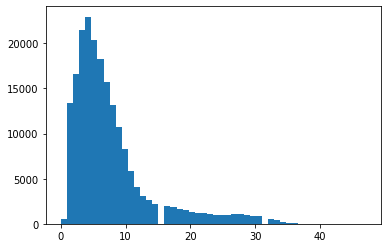

In [18]:
import matplotlib.pyplot as plt

plt.hist([len(s) for s in train_sequences] 
         + [len(s) for s in test_sequences], bins=50)

print('maximun length : {}'.format(max(len(l) for l in train_sequences)))
print('average length : {}'.format(sum(map(len, train_sequences))/len(train_sequences)))

In [19]:
np.unique(train_labels, return_counts=True)

(array([0, 1], dtype=int32), array([75173, 74827]))

In [20]:
max_length = 30

train_padded = pad_sequences(train_sequences,
                maxlen=max_length, truncating='post', padding='post')


test_padded = pad_sequences(test_sequences,
                maxlen=max_length, truncating='post', padding='post')

In [21]:
print(train_padded.shape)
print(test_padded.shape)
train_padded[0]

(150000, 30)
(50000, 30)


array([  17,  915,    5, 6695, 1079,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

## sequence data 를 sentence 로 reverse conversion

In [22]:
text = train_padded[0]
print(' '.join([tokenizer.index_word.get(i, '<pad>') for i in text]))
print()
print(train_sentences[0])

아 더빙 진짜 짜증나네요 목소리 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

아 더빙 진짜 짜증나네요 목소리


## model define

In [23]:
model = Sequential([
    Embedding(vocab_size, 100),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,092,801
Trainable params: 1,092,801
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,092,801
Trainable params: 1,092,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=5)

In [26]:
import time
s = time.time()

num_epochs = 30
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, batch_size=128,
          validation_data=(test_padded, test_labels), 
                    verbose=1, callbacks=[early_stop])

print(time.time() - s)

Epoch 1/30
1172/1172 [==============================] - 57s 19ms/step - loss: 0.4985 - accuracy: 0.7295 - val_loss: 0.4092 - val_accuracy: 0.7976
Epoch 2/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.3685 - accuracy: 0.8159 - val_loss: 0.4076 - val_accuracy: 0.7968
Epoch 3/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.3366 - accuracy: 0.8309 - val_loss: 0.4229 - val_accuracy: 0.7921
Epoch 4/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.3072 - accuracy: 0.8456 - val_loss: 0.4487 - val_accuracy: 0.7918
Epoch 5/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.2829 - accuracy: 0.8558 - val_loss: 0.4657 - val_accuracy: 0.7898
Epoch 6/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.2613 - accuracy: 0.8672 - val_loss: 0.5189 - val_accuracy: 0.7847
Epoch 7/30
1172/1172 [==============================] - 22s 19ms/step - loss: 0.2381 - accuracy: 0.8763 - val_loss: 0.5668 -

In [27]:
results = model.evaluate(test_padded, test_labels, verbose=0)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

loss: 0.567
accuracy: 0.779


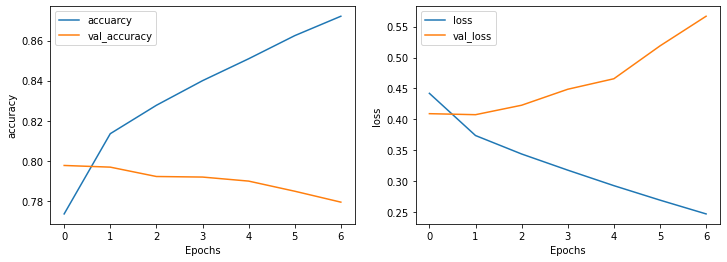

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [29]:
# sample_text = ['다시는 보고 싶지 않은 짜증나는 영화']
sample_text = ['권하고 싶지 않은 지루한 영화']
# sample_text = ['정말 훌륭한 영화였다']
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')

In [30]:
['positive' if model.predict([sample_padded]) >= 0.5 else 'negative']

['negative']